# MoE


In [169]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import os 
import sys
import torch


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from moe_model import MoE as MoE_raw, MLP as MoE_Expert


class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        # Replace the final softmax layer with an identity layer
        self.soft = nn.Identity()


In [170]:
def train_and_evaluate_trial(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoE model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    model = MoE_raw(
        input_size=X_train.shape[1],
        output_size=2,
        num_experts=params['num_experts'],
        hidden_size=params['hidden_size'],
        k=params['k']
    )
    model.experts = nn.ModuleList([
        MoE_Expert_Logits(
            input_size=X_train.shape[1],
            output_size=2,
            hidden_size=params['hidden_size']
        ) for _ in range(model.num_experts)
    ])
    model.to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred, aux_loss = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor) + aux_loss
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, val_aux_loss = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor) + val_aux_loss
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _ = model(X_val_tensor)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        # Get detailed metrics from classification report for class '1'
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'num_experts': params['num_experts'],
            'hidden_size': params['hidden_size'],
            'k': params['k'],
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


In [171]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'input_moe_rfe_fulldataset.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False) 
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_moe_added.csv' not found. Please ensure the correct data file is present.")

# --- 2. Define the Best Hyperparameters ---
best_params = {
    'num_experts': 4,
    'hidden_size': 32,
    'k': 3
}
print(f"\n🔹 Using best hyperparameters: {best_params}")

# --- 3. Prepare the Final Model ---
# Combine training and validation data for final training
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best model on combined Train+Validation data...")

# Create the final model instance with the best parameters
final_model = MoE_raw(
    input_size=X_train_val.shape[1],
    output_size=2,
    num_experts=int(best_params['num_experts']),
    hidden_size=int(best_params['hidden_size']),
    k=int(best_params['k'])
)
final_model.experts = nn.ModuleList([
    MoE_Expert_Logits(
        input_size=X_train_val.shape[1],
        output_size=2,
        hidden_size=int(best_params['hidden_size'])
    ) for _ in range(final_model.num_experts)
])


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (926, 31)

🔹 Using best hyperparameters: {'num_experts': 4, 'hidden_size': 32, 'k': 3}

Retraining the best model on combined Train+Validation data...


In [192]:
# --- 1. Train the final model ---
# We reuse the evaluation function as a training function here
final_results = train_and_evaluate_trial(
    best_params,
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

# --- 2. Print the final performance metrics on the test set ---
print("\n\n" + "="*40 + "\n✅ FINAL MODEL PERFORMANCE ON TEST SET\n" + "="*40)
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")

# --- 3. Save the final trained model ---
# model_save_path = 'best_moe_rfe_model.pth'
# torch.save(final_model.state_dict(), model_save_path)
# print(f"\n✅ Best MoE model saved to '{model_save_path}'")




✅ FINAL MODEL PERFORMANCE ON TEST SET
  - Accuracy:    0.7522
  - ROC-AUC:     0.8011
  - F1-Score:    0.7639
  - Precision:   0.7381
  - Recall:      0.7915
  - Cohen Kappa: 0.5038




🚀 Starting SHAP Analysis

--- Analyzing Overall MoE Model ---

Generating separate SHAP plots for the overall model...


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


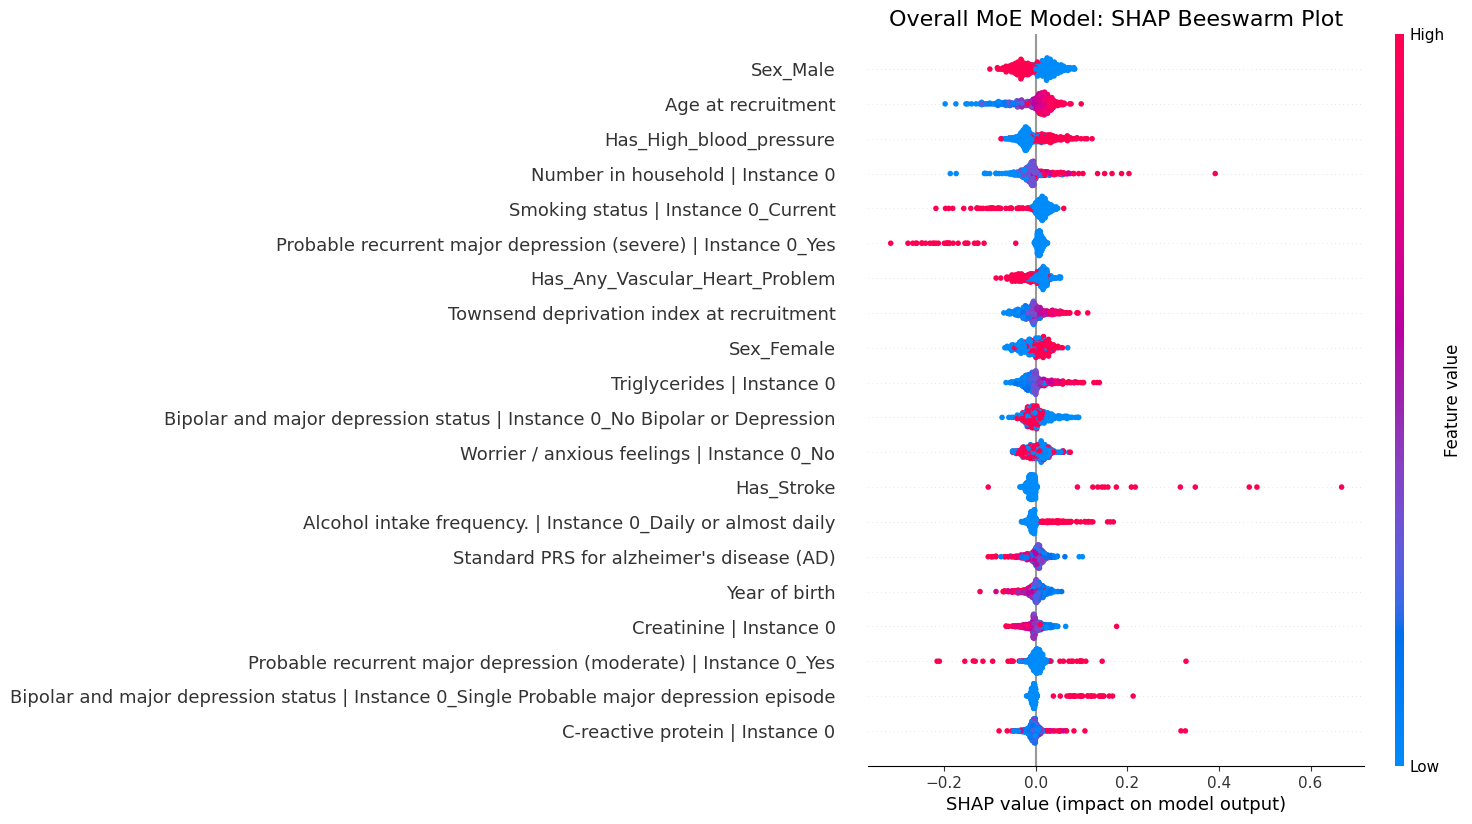

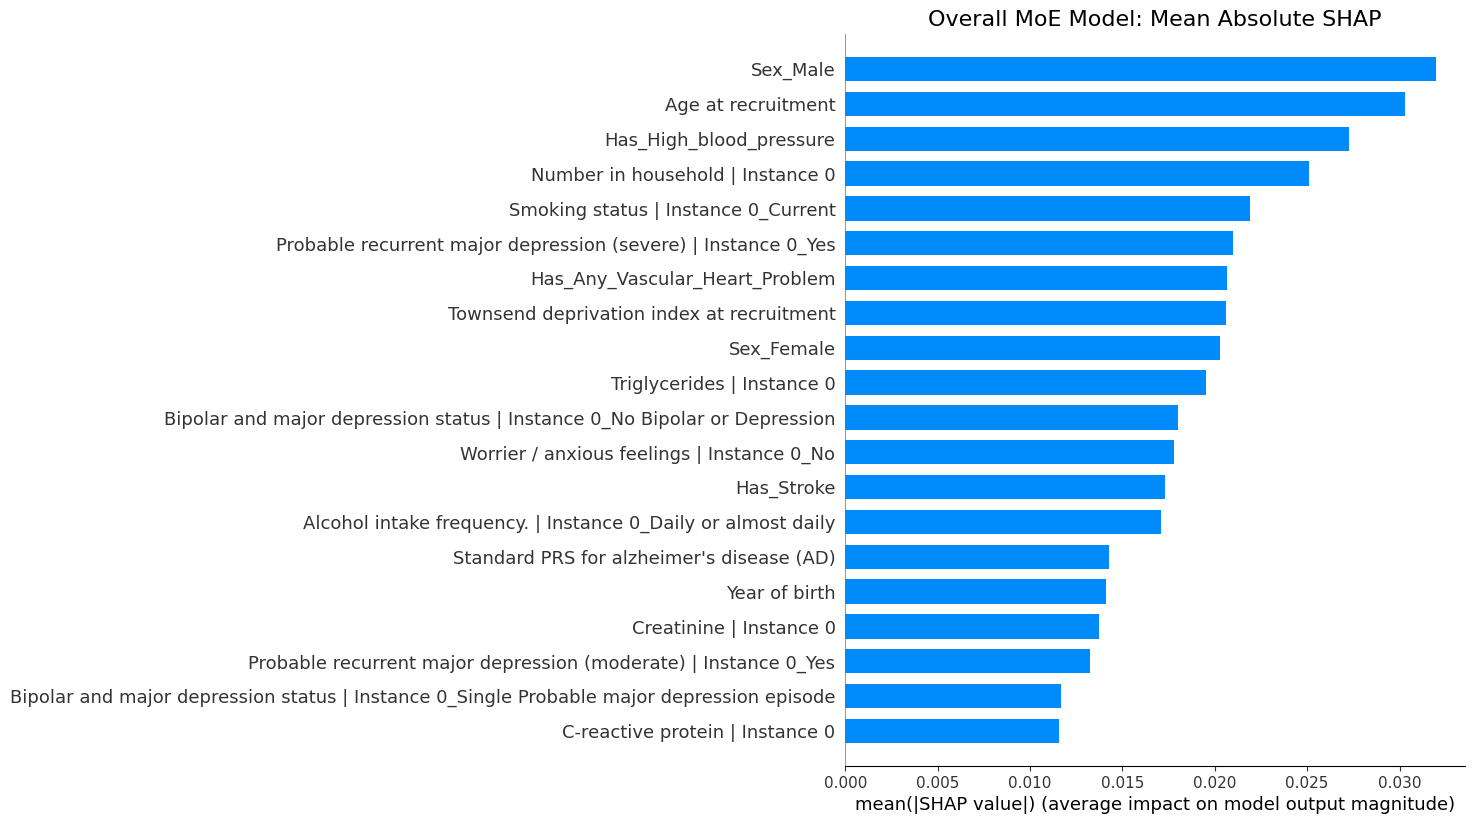



🕵️ Analyzing Expert Specializations

--- Analyzing 119 samples routed to Expert 1 ---
Generating separate plots for Expert 1...


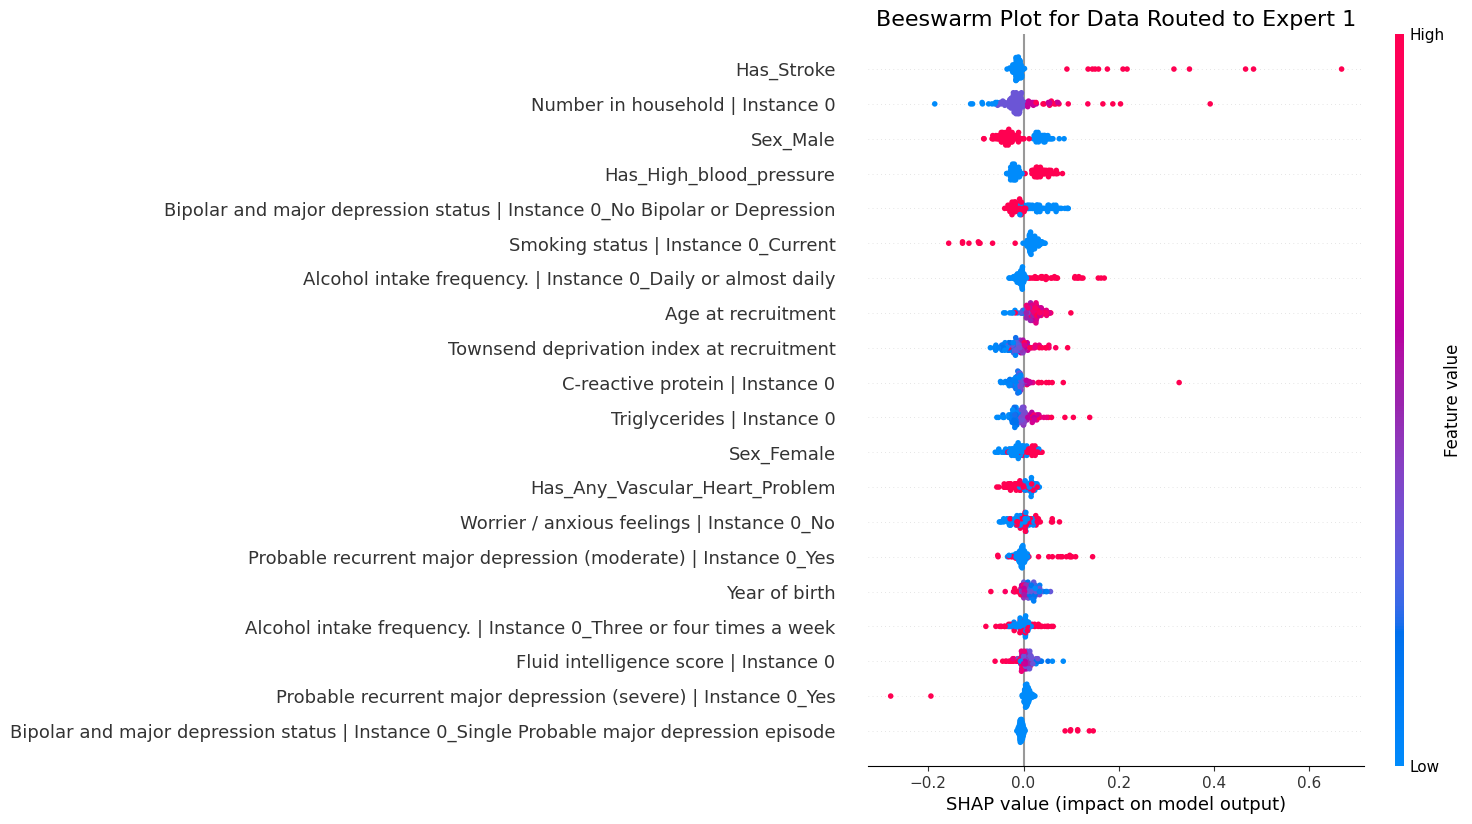

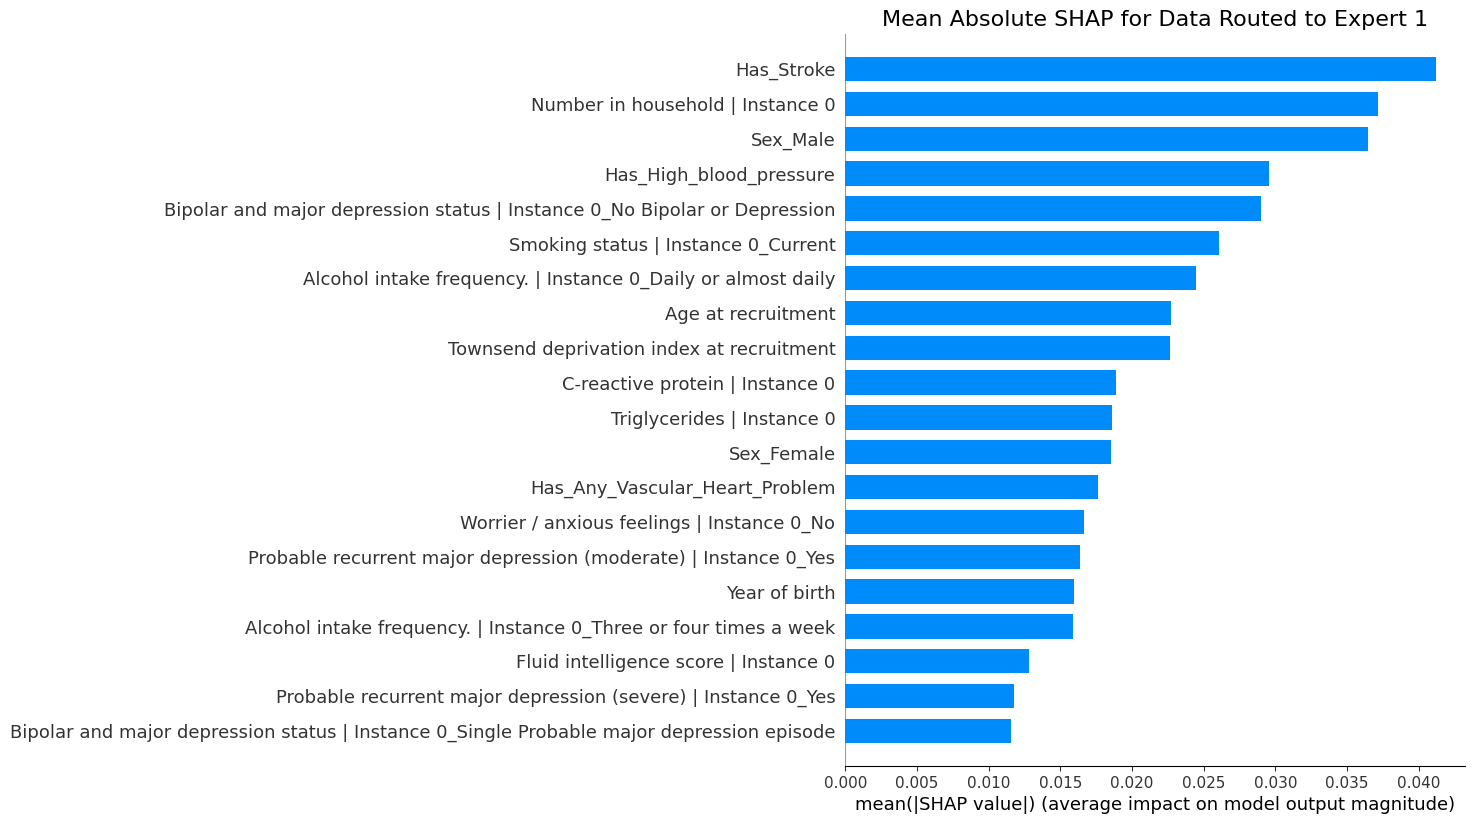


--- Analyzing 140 samples routed to Expert 2 ---
Generating separate plots for Expert 2...


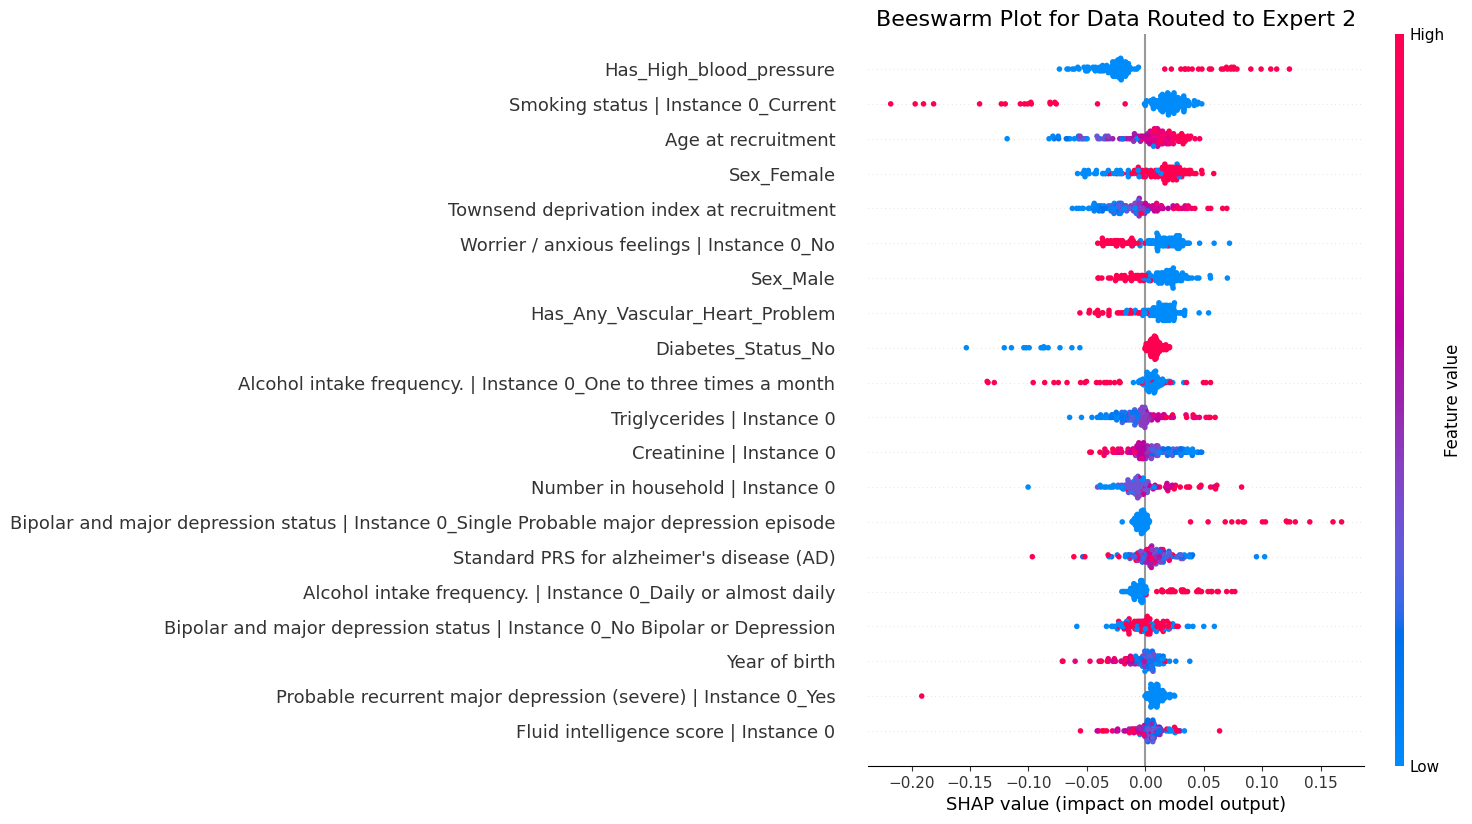

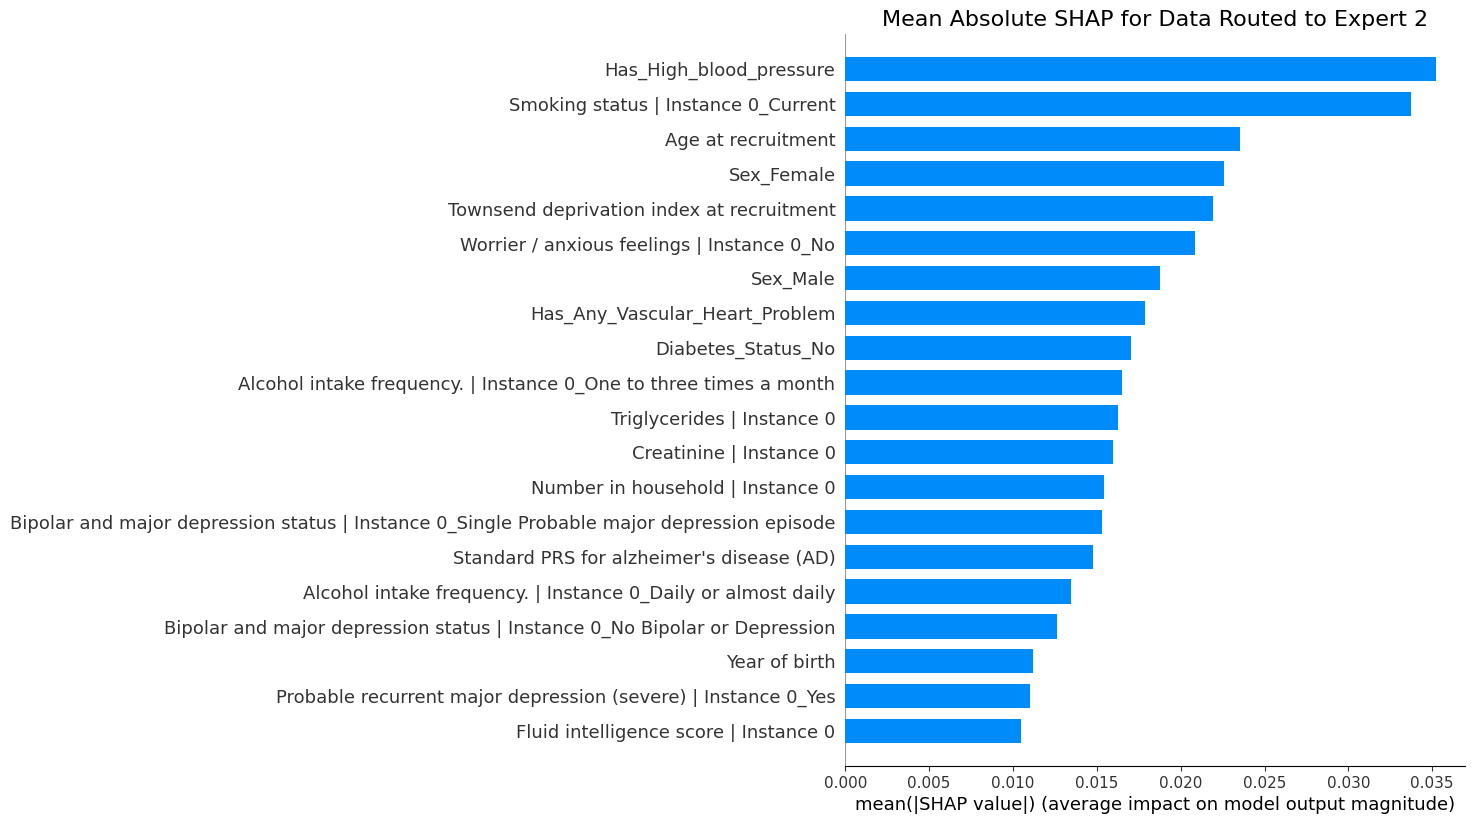


--- Analyzing 112 samples routed to Expert 3 ---
Generating separate plots for Expert 3...


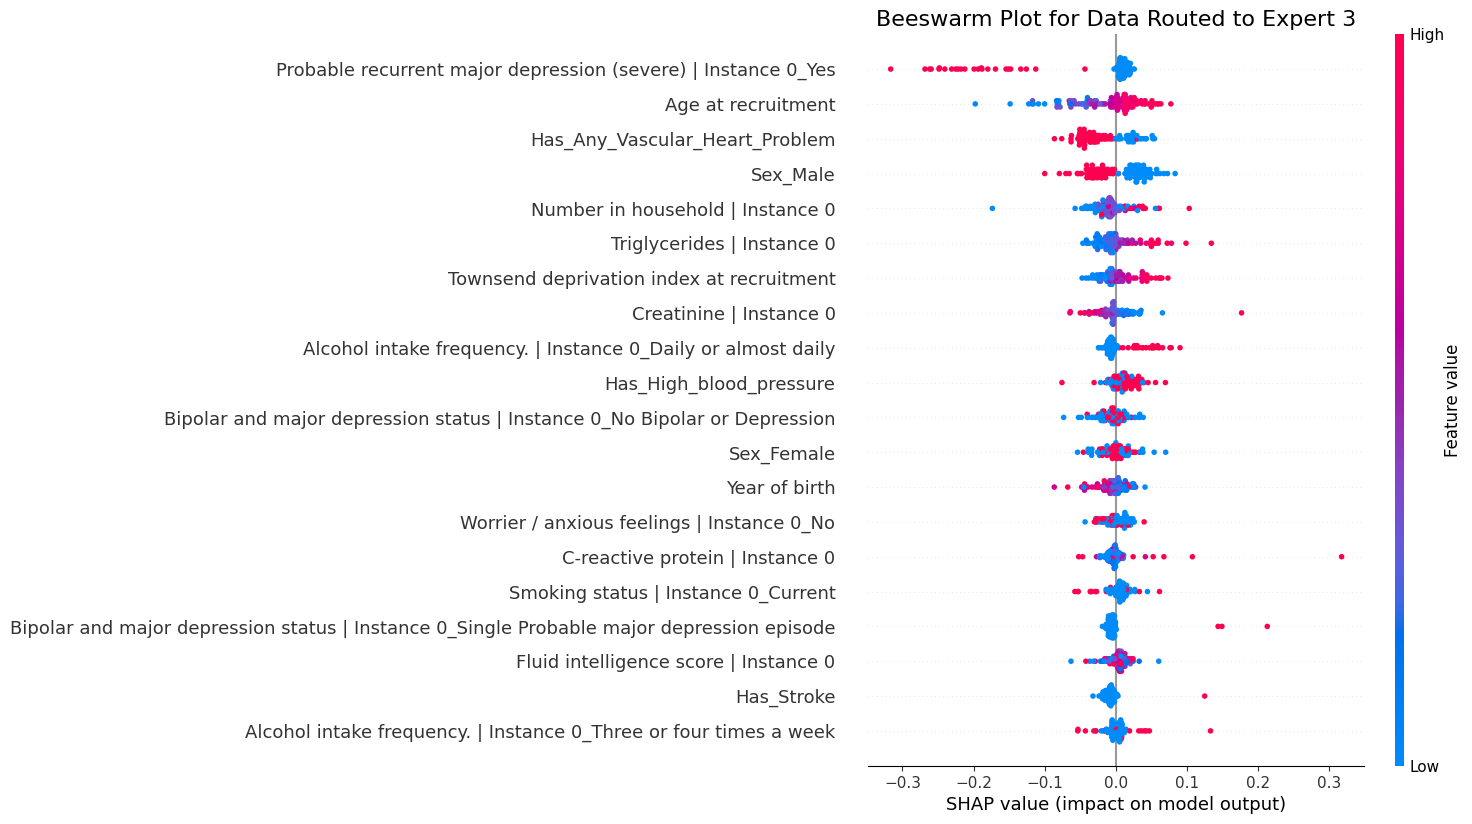

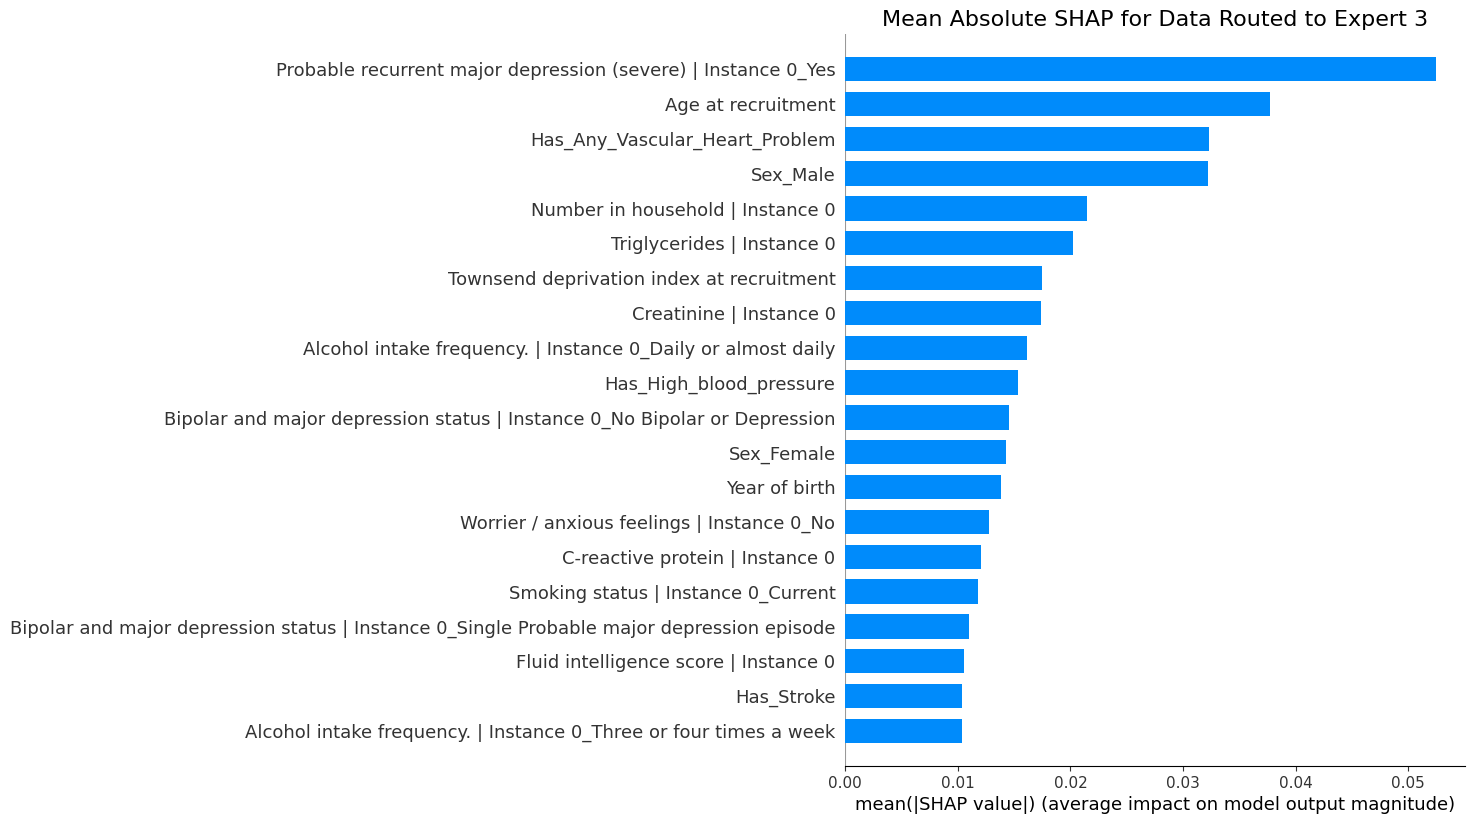


--- Analyzing 93 samples routed to Expert 4 ---
Generating separate plots for Expert 4...


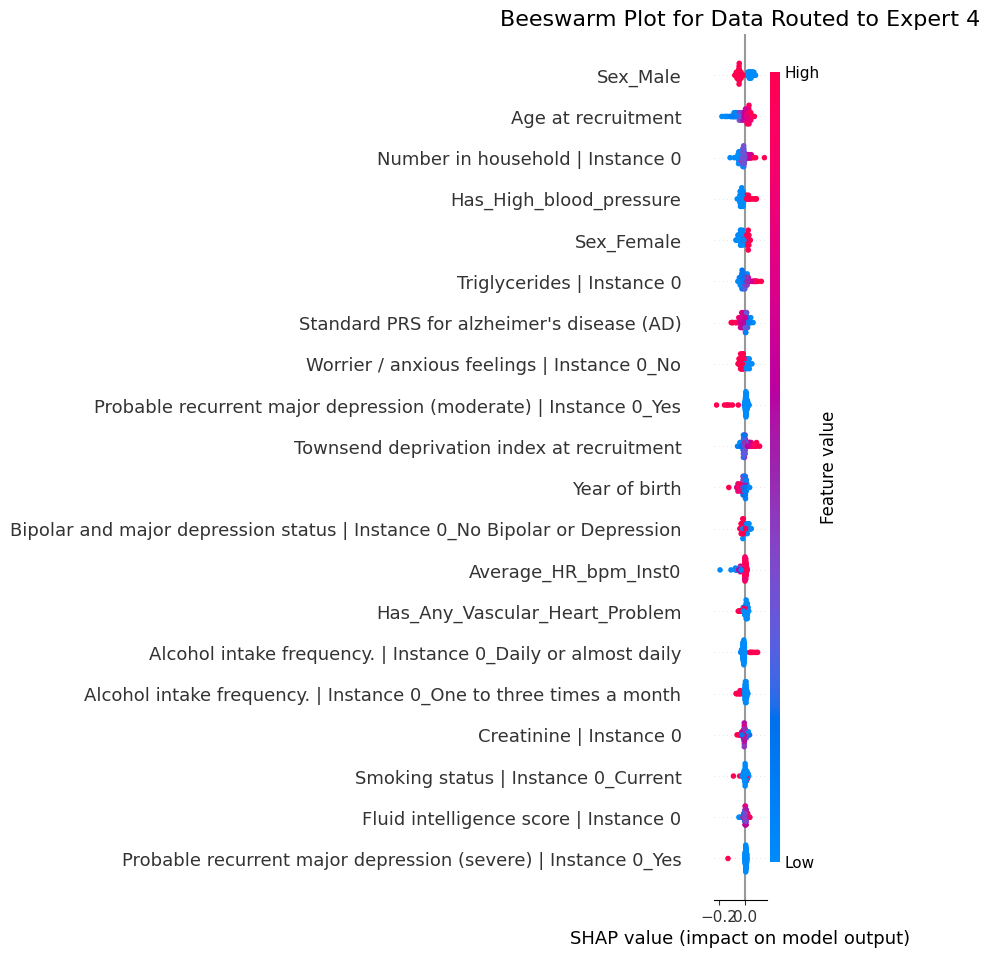

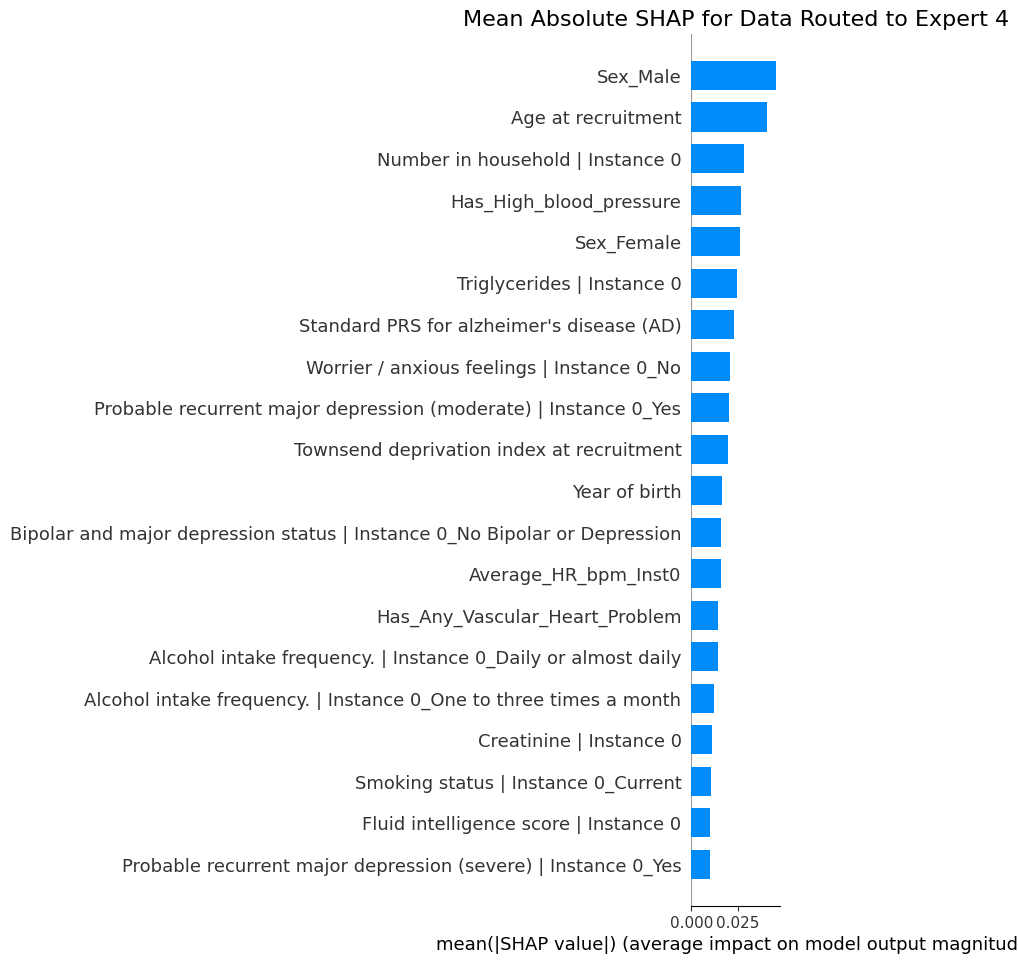

In [173]:
import shap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ===================================================================
# SHAP Analysis of the Final, Best MoE Model
# ===================================================================
print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis\n" + "="*40)

# --- 1. Prepare data and calculate SHAP for the OVERALL model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)
final_model.eval()

background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

print("\n--- Analyzing Overall MoE Model ---")
# Define a wrapper for the SHAP explainer
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        self.model.train()
        pred, _ = self.model(x)
        return pred

# Calculate SHAP values for the entire model once
shap_model_wrapper = ShapModelWrapper(final_model)
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)
shap_values = explainer.shap_values(test_tensor)

# --- MODIFIED: Plot the OVERALL model's SHAP analysis separately ---
print("\nGenerating separate SHAP plots for the overall model...")

# Plot 1: Beeswarm Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
plt.title("Overall MoE Model: SHAP Beeswarm Plot", fontsize=16)
plt.show()

# Plot 2: Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Overall MoE Model: Mean Absolute SHAP", fontsize=16)
plt.show()


# ===================================================================
# SHAP Analysis for INDIVIDUAL Experts
# ===================================================================
print("\n\n" + "="*40 + "\n🕵️ Analyzing Expert Specializations\n" + "="*40)

# --- 3. Get the gating decisions for the entire test set ---
with torch.no_grad():
    gating_logits = test_tensor @ final_model.w_gate
    
    # Find the winning expert for each sample (the one with the highest logit)
    chosen_experts = torch.argmax(gating_logits, dim=1).cpu().numpy()

# --- 4. Loop through each expert and analyze the data routed to it ---
num_experts = final_model.num_experts
for i in range(num_experts):
    # Find the indices of all samples that were routed to the current expert 'i'
    samples_for_this_expert_indices = np.where(chosen_experts == i)[0]

    # Check if any samples were actually routed to this expert
    if len(samples_for_this_expert_indices) == 0:
        print(f"\n--- No samples were primarily routed to Expert {i+1}. Skipping. ---")
        continue

    print(f"\n--- Analyzing {len(samples_for_this_expert_indices)} samples routed to Expert {i+1} ---")

    # Filter the OVERALL shap_values and test_data for this expert's specific subset
    shap_subset = shap_values[1][samples_for_this_expert_indices]
    X_test_subset = X_test_scaled[samples_for_this_expert_indices]

    # --- Create separate plots for this expert's data ---
    print(f"Generating separate plots for Expert {i+1}...")
    
    # Beeswarm Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="dot", show=False)
    plt.title(f"Beeswarm Plot for Data Routed to Expert {i+1}", fontsize=16)
    plt.show()

    # Bar Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="bar", show=False)
    plt.title(f"Mean Absolute SHAP for Data Routed to Expert {i+1}", fontsize=16)
    plt.show()



🚦 Analyzing MoE Expert Routing on Test Data

--- Routing Percentage Table (%) ---
This table shows the percentage of test samples routed to each expert.


,Expert 1,Expert 2,Expert 3,Expert 4
Gating Layer,25.65%,30.17%,24.14%,20.04%




--- Routing Percentage Heatmap ---


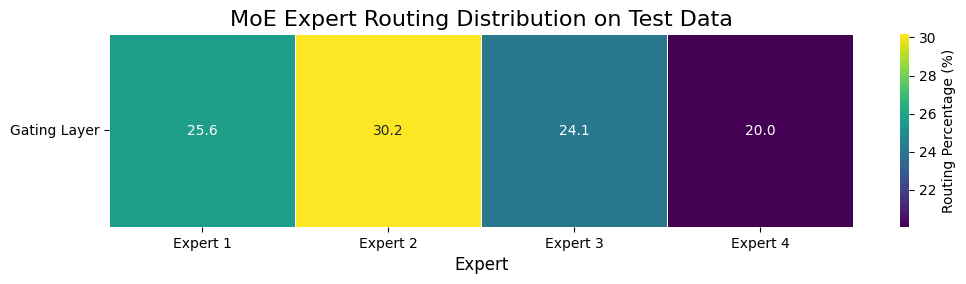

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import torch
import numpy as np

# ===================================================================
# MoE Routing Analysis
# ===================================================================
print("\n\n" + "="*40 + "\n🚦 Analyzing MoE Expert Routing on Test Data\n" + "="*40)

try:
    # --- 1. Get Gating Decisions from the Final Model ---
    final_model.eval()
    with torch.no_grad():
        # Get the gating scores (logits)
        gating_logits = test_tensor @ final_model.w_gate
        # Find the winning expert for each sample
        chosen_experts = torch.argmax(gating_logits, dim=1).cpu().numpy()

    # --- 2. Calculate Routing Percentages ---
    num_samples = test_tensor.shape[0]
    num_experts = final_model.num_experts
    
    # Count how many times each expert was chosen
    counts = np.bincount(chosen_experts, minlength=num_experts)
    
    # Convert counts to a percentage
    percentages = (counts / num_samples) * 100
    
    # --- 3. Create and Display the Routing Table ---
    expert_names = [f'Expert {j+1}' for j in range(num_experts)]
    routing_df = pd.DataFrame([percentages], index=['Gating Layer'], columns=expert_names)

    print("\n--- Routing Percentage Table (%) ---")
    print("This table shows the percentage of test samples routed to each expert.")
    display(routing_df.style.format("{:.2f}%"))

    # --- 4. Create and Display the Routing Heatmap ---
    print("\n\n--- Routing Percentage Heatmap ---")
    plt.figure(figsize=(12, 2.5)) # Adjusted figsize for a single-row heatmap
    sns.heatmap(
        routing_df, 
        annot=True,          # Show the percentage values in the cells
        fmt=".1f",           # Format values to one decimal place
        cmap="viridis",      # Use the 'viridis' color map
        linewidths=.5,       # Add thin lines between cells
        cbar_kws={'label': 'Routing Percentage (%)'} # Add a label to the color bar
    )
    plt.title("MoE Expert Routing Distribution on Test Data", fontsize=16)
    plt.xlabel("Expert", fontsize=12)
    plt.ylabel("") 
    plt.yticks(rotation=0) 
    plt.show()

except NameError:
    print("Error: `final_model` or `test_tensor` not found. ")

In [175]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# ===================================================================
# Calculate Overall Expert Specialization
# ===================================================================
print("\n\n" + "="*40 + "\n 📊 Calculating Overall Expert Specialization \n" + "="*40)

try:
    # --- Step 1: Extract Mean Absolute SHAP Vector for Each Expert ---
    mean_abs_shap_vectors = {}
    num_experts = final_model.num_experts
    
    # This loop re-uses 'shap_values' and 'chosen_experts' from the previous SHAP analysis cell.
    for i in range(num_experts):
        # Find the indices of all samples that were routed to the current expert 'i'
        samples_for_this_expert_indices = np.where(chosen_experts == i)[0]

        # Skip experts that received no data
        if len(samples_for_this_expert_indices) == 0:
            continue

        # Filter the overall shap_values for this expert's subset
        shap_subset = shap_values[1][samples_for_this_expert_indices]
        
        # Calculate the mean absolute SHAP values for this expert and store it
        mean_vector = np.abs(shap_subset).mean(axis=0)
        mean_abs_shap_vectors[f'Expert {i+1}'] = mean_vector
        
    print(f"Extracted feature importance vectors for {len(mean_abs_shap_vectors)} active experts.")

    # --- Step 2: Compute the Specialization Index ---
    if len(mean_abs_shap_vectors) < 2:
        print("\nCannot calculate specialization with less than two active experts.")
    else:
        # Combine the vectors into a single matrix
        shap_matrix = np.array(list(mean_abs_shap_vectors.values()))
        
        # Compute the pairwise cosine similarity matrix
        similarity_matrix = cosine_similarity(shap_matrix)
        
        # Get the unique off-diagonal comparisons (from the upper triangle of the matrix)
        indices = np.triu_indices(shap_matrix.shape[0], k=1)
        off_diagonal_values = similarity_matrix[indices]
        mean_similarity = np.mean(off_diagonal_values)
        
        # Calculate the final Specialization Index
        specialization_index = 1 - mean_similarity

        print(f"\n--- Overall Specialization Analysis ---")
        print(f"Average similarity between experts: {mean_similarity:.4f}")
        print(f"Overall Specialization Index: {specialization_index:.4f}")


except NameError:
    print("Error: `shap_values` or `chosen_experts` not found. Please run the main SHAP analysis block first.")



 📊 Calculating Overall Expert Specialization 
Extracted feature importance vectors for 4 active experts.

--- Overall Specialization Analysis ---
Average similarity between experts: 0.8443
Overall Specialization Index: 0.1557
